In [ ]:
!pip install transformers==3.0.0

In [ ]:
import torch

if torch.cuda.is_available():     
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_csv('drive/My Drive/DL-Final-Project/Dataset/Subset2_Preprocessed_NoHashtag.csv',  lineterminator='\n')

In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
tokenizer

In [ ]:
tweets = df.Tweets.values
labels = df.Labels.values
labels[labels==-1] = 0

In [ ]:
import numpy as np
print(labels.mean())
freq = np.array(labels)
freq
zeros = np.where(freq == 0, 1, 0)
zeros = zeros.sum()
ones = np.where(freq == 1, 1, 0)
ones = ones.sum()

0.7894227668494034


In [ ]:
max_len = 0

# For every sentence...
for tweet in tweets:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  41


In [ ]:
import torch
input_ids = []
attention_masks = []

# For every sentence...
for tweet in tweets:
    
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 50,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

Streaming output truncated to the last 5000 lines.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to

Original:  aurora cardiovascular services shah prakash d md is rated gununfriendly kenosha wisconsin 2afriendly 
Token IDs: tensor([  101, 13158, 22935,  2578,  7890, 22233,  1040,  9108,  2003,  6758,
         3282,  4609, 19699,  9013, 18718,  6358, 17369,  2050,  5273, 23409,
        19699,  9013, 18718,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,341 training samples
1,861 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 6

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np
import torch.nn as nn

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
weights = torch.tensor([1/zeros, 1/ones])
weights = weights / torch.sum(weights)
loss_fn = nn.CrossEntropyLoss(weight = weights).float().to(device)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        

        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask,
                              labels=b_labels)
        #print(logits)
        logits = output[1]
        #print(output)
        #print("afsdfsdf")
        loss = loss_fn(logits, b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
       
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
          output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask, 
                                   labels=b_labels)
        logits = output[1]
        loss = loss_fn(logits, b_labels)  
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 6 ========
Training...
  Batch    40  of    136.    Elapsed: 0:00:13.
  Batch    80  of    136.    Elapsed: 0:00:26.
  Batch   120  of    136.    Elapsed: 0:00:39.

  Average training loss: 0.47
  Training epcoh took: 0:00:44

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.35
  Validation took: 0:00:06

======== Epoch 2 / 6 ========
Training...
  Batch    40  of    136.    Elapsed: 0:00:12.
  Batch    80  of    136.    Elapsed: 0:00:25.
  Batch   120  of    136.    Elapsed: 0:00:37.

  Average training loss: 0.28
  Training epcoh took: 0:00:42

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.27
  Validation took: 0:00:06

======== Epoch 3 / 6 ========
Training...
  Batch    40  of    136.    Elapsed: 0:00:13.
  Batch    80  of    136.    Elapsed: 0:00:25.
  Batch   120  of    136.    Elapsed: 0:00:37.

  Average training loss: 0.20
  Training epcoh took: 0:00:42

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.30
  Validation too

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.47,0.35,0.92,0:00:44,0:00:06
2,0.28,0.27,0.90,0:00:42,0:00:06
3,0.20,0.30,0.92,0:00:42,0:00:06
4,0.14,0.29,0.91,0:00:41,0:00:06
5,0.10,0.35,0.92,0:00:42,0:00:06
6,0.07,0.36,0.92,0:00:42,0:00:06


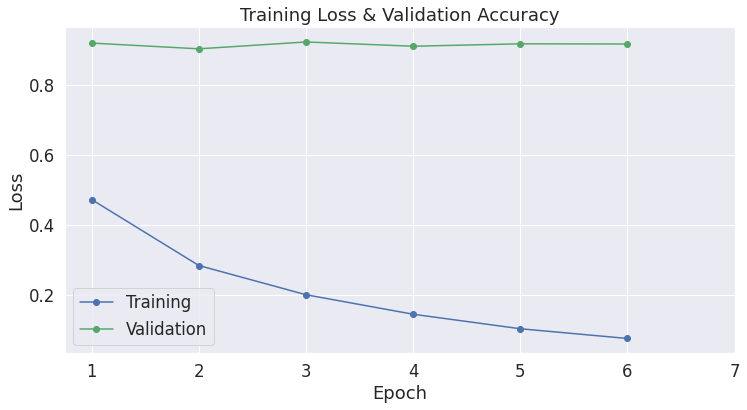

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Accur.'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training Loss & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7])

plt.show()

# EMBEDDINGS GENERATED HERE

In [ ]:
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    labels = []
    predictions = []
    hidden_states = []
    true_labels = []
    # Evaluate data for one epoch
    for batch in validation_dataloader:
       
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
          output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Move logits and labels to CPU
        hidden = output[2][0][:,-4:,:].mean(dim=1)
        hidden_states.append(hidden.cpu().numpy())
        true_labels.append(b_labels.cpu().numpy())
        logits = output[1]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        pred_flat = np.argmax(logits, axis=1).flatten()
        predictions = np.concatenate((predictions, pred_flat))
        labels = np.concatenate((labels, label_ids))
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.

In [ ]:
true_labels = true_labels[:-1]
true_labels = np.array(true_labels)
true_labels = true_labels.reshape(-1, 1)
true_labels.shape

(1856, 1)

In [ ]:
hidden_states = hidden_states[:-1]
hidden_states = np.array(hidden_states)
print(hidden_states.shape)
hidden_states = hidden_states.reshape(-1, hidden_states.shape[-1])
hidden_states.shape

(58, 32, 768)


(1856, 768)

In [ ]:
np.savez('final_embeddings_untrained.npz', labels=true_labels, embeddings=hidden_states)

## Analysis Before Weight Balancing

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels, predictions)

array([[ 272,  122],
       [  53, 1414]])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(labels, predictions)

(array([0.83692308, 0.92057292]),
 array([0.69035533, 0.96387185]),
 array([0.7566064 , 0.94172494]),
 array([ 394, 1467]))

## Analysis After Weight Balancing

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels, predictions)

array([[ 297,   84],
       [  54, 1426]])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(labels, predictions)

(array([0.84615385, 0.94437086]),
 array([0.77952756, 0.96351351]),
 array([0.81147541, 0.95384615]),
 array([ 381, 1480]))

# BERT with Clustering

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model_new = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model_new.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model_new.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 6

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
from pathlib import Path

from tqdm import tqdm
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torchvision import transforms as T
from torchvision.utils import make_grid
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import NearestNeighbors


In [ ]:
raw_dataset = TensorDataset(input_ids, attention_masks)

In [ ]:
raw_dataset

In [ ]:
pca_dim = 10
kmeans_clusters = 2

# convnet
batch_size = 64
num_classes = 2
num_epochs = 6

In [ ]:
pca = IncrementalPCA(n_components=pca_dim, batch_size=512, whiten=True)
kmeans = MiniBatchKMeans(n_clusters=kmeans_clusters, batch_size=512, init_size=3*kmeans_clusters)

In [ ]:
def extract_features(model, dataset, batch_size=64):
    """
    Gets the output of a pytorch model given a dataset.
    """
    loader = DataLoader(
            dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
    
    features = []
    for batch in loader:
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        batch = b_input_ids.to(device)
        batch_mask = b_input_mask.to(device)
        outputs = model(batch, 
                                   token_type_ids=None, 
                                   attention_mask=batch_mask)
        hidden_states = outputs[1][1:]
        token_embeddings = hidden_states[-1]
        output = torch.squeeze(token_embeddings, dim=0)
        output = torch.mean(output, dim = 1)
        features.append(output.detach().cpu())
    return torch.cat(features).numpy() 

In [ ]:
loader

NameError: ignored

In [ ]:
raw_dataset[1][0]

tensor([  101,  2274, 26521,  2038,  2028,  2691,  5783,  2000,  4126,  4409,
         2073,  2024,  1996,  2111,  2007,  8040,  2102, 28394,  3215, 13256,
         3995,  2615,  8040, 18155,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
import statistics
def cluster(pca, kmeans, model, dataset, batch_size, return_features=False):
    features = extract_features(model, dataset, batch_size)  
    reduced = pca.fit_transform(features)
    pseudo_labels = list(kmeans.fit_predict(reduced))
    one_count = sum(pseudo_labels)
    zero_count = len(pseudo_labels) - one_count

    if one_count == 0:
      randomlist = random.sample(range(0, len(pseudo_labels)), len(pseudo_labels)/ 4)
      for i in randomlist:
        print(i)
        pseudo_labels[i] = 1
    elif zero_count == 0:
      randomlist = random.sample(range(0, len(pseudo_labels)), len(pseudo_labels)/ 4)
      for i in randomlist:
        pseudo_labels[i] = 0
  
    print(statistics.mean(pseudo_labels))
    if return_features:
        return pseudo_labels, features
    return pseudo_labels

In [ ]:
def train_epoch(model, optimizer, dataset, batch_size = 64):
    loader = DataLoader(
            dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
    total_loss = 0

    for batch in loader:
        optimizer.zero_grad()
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        labels = batch[2]
        #print(labels.size())
        labels = labels.to(device)
        batch = b_input_ids.to(device)
        batch_mask = b_input_mask.to(device)
        #print(b_input_mask.size())
        outputs = model(batch, 
                                   token_type_ids=None, 
                                   attention_mask=batch_mask)
        out = outputs[0]
        #print(labels.size())
        loss = F.cross_entropy(out, torch.squeeze(labels.long()))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

In [ ]:
for i in range(num_epochs):
    pseudo_labels = cluster(pca, kmeans, model_new, train_dataset, 64) # generate labels
    #print((torch.unsqueeze(torch.tensor(pseudo_labels), 1)).size())
    statistics.mean(pseudo_labels)
    pseudo_labels = torch.unsqueeze(torch.tensor(pseudo_labels), 1)
    #print(train_dataset[:][0].size())
    #print(train_dataset[:][1].size())
    dataset = TensorDataset(train_dataset[:][0], train_dataset[:][1], pseudo_labels)
    train_size = int(0.7 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    labeled_dataset = train_dataset
    train_epoch(model_new, optimizer, labeled_dataset, 64) # train for one epoch

0
0
0
0
0


ValueError: ignored

6